## **Fig2i,j** ##
**One can compute PAGA in this notebook or read a prepared one**

In [1]:
import scvelo as scv
#import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import pandas as pd

In [2]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import *
from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [3]:
# model_name = 'processed bonemarrow'
# model_name = 'EG_ab_dyn'
#model_name = 'DentateGyrus'
[k_nei, K, L] = [10, 3, 10]

data_name = 'DG_bin_ppt.h5ad'
result_path = 'Eigen_PAGA_results/'+data_name+' '+str([k_nei,K,L])+'/'
encoder_path = 'main_results/'+'DG_bin_ppt'+' '+str([k_nei,K,L])+'/'
data_path='data/'
#data_name = 'BoneMarrow/human_cd34_bone_marrow.h5ad'
#data_name = 'processed bonemarrow.h5ad'

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os
os.makedirs(result_path, exist_ok=True)

In [4]:
adata0=scv.read(data_path+data_name, cache=True)

In [5]:
adata0

AnnData object with n_obs × n_vars = 3139 × 678
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'palantir_pseudotime', 'palantir_entropy'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'ClusterName_colors', 'DM_EigenValues', 'neighbors', 'palantir_waypoints', 'pca', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'DM_EigenVectors', 'DM_EigenVecto

In [6]:

# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'
cmap = plt.colormaps['Spectral_r']

import scanpy as sc
from scipy.sparse import csr_matrix, identity
adata=adata0.copy()
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
# cell_ppt = adata.obs['palantir_pseudotime'].values
Xs = adata.layers['Ms']#adata.X.A#
# X = Xs
X = Xs

row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = (adata.obsp['distances']+csr_matrix(np.eye(adata.obsp['distances'].shape[0]))).indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

dc=np.amax(adata.obsp['distances'])

cell_nei=col.reshape([-1,k_nei])
nei_w=[]
rho_arr=[]
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

A = A_mat

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
##Fisher matrix
encoder = torch.load(encoder_path+'encoder.pt')
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()
diag_elements = np.concatenate([1 / sigma_learned ** 2, 2 / sigma_learned ** 2], axis=-1)
Fisher_g = np.zeros((X.shape[0], 2 * L, 2 * L))
for i in range(X.shape[0]):
    np.fill_diagonal(Fisher_g[i], diag_elements[i])

In [8]:
#Fisher_g = np.load(result_path+'随机基因2055/'+'k_nei=10/K=3 L=6/'+'Fisher_g.npy')

In [9]:
def EigenIF(Fisher_g):
    n,L,_ = Fisher_g.shape
    L=int(L/2)
    Eigenvalue = np.zeros((n,L))
    for i in range(n):
        for j in range(L):
            Eigenvalue[i,j] = Fisher_g[i,j,j]
    sorted_Eigenvalue = np.sort(Eigenvalue, axis=1)
    sorted_Eigenvalue = sorted_Eigenvalue[:, ::-1]
    relative_Eigenvalue = sorted_Eigenvalue[:,1:]/sorted_Eigenvalue[:,0].reshape(n,1)
    return Eigenvalue,sorted_Eigenvalue,relative_Eigenvalue

Eigenvalue,sorted_Eigenvalue,relative_Eigenvalue = EigenIF(Fisher_g)

In [10]:
# # Compute PAGA
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata)
# sc.tl.leiden(adata)
# sc.tl.paga(adata)
# sc.pl.paga(adata, plot=True)
# sc.tl.umap(adata, init_pos='paga')
# sc.pl.umap(adata, color='leiden',edges=True)

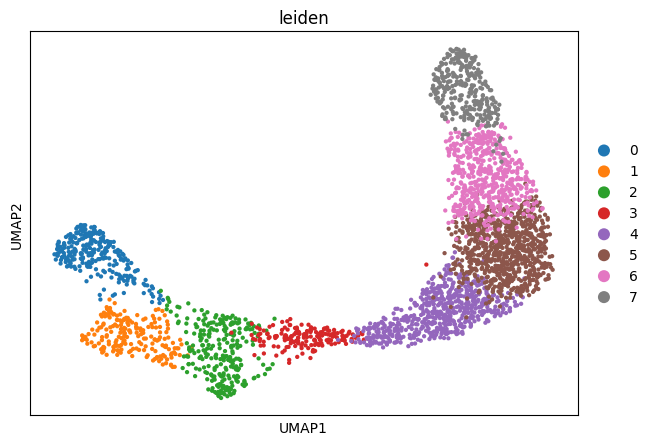

In [11]:
clusters = np.load('PAGA_DG.npy')
adata.obs['leiden'] = clusters
adata0.obs['leiden'] = adata.obs['leiden']
sc.pl.scatter(adata0, basis = 'umap', color='leiden', save = 'clusters_PAGA.png')


In [12]:
clusters = adata.obs['leiden']
# np.save(result_path+'PAGA.npy', np.array(clusters.tolist()))

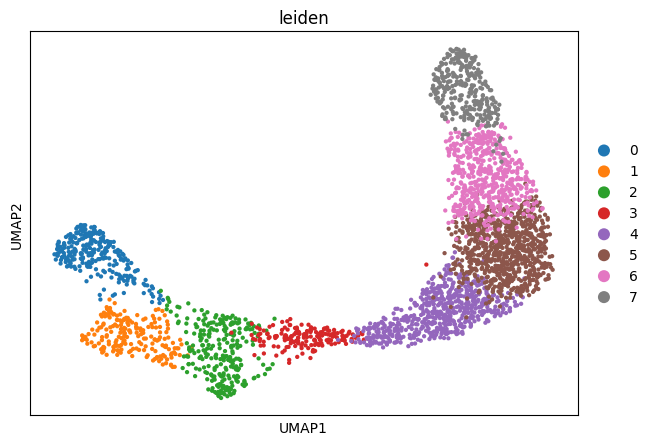

In [13]:
# categories = ['4','6','5','7','1','0','2','3']
# tmp = []
# for i in range(len(clusters)):
#     tmp.append(str(np.where(np.array(categories) == clusters[i])[0][0]))
# adata.obs['leiden'] = tmp
sc.pl.scatter(adata, basis = 'umap', color='leiden', save = 'clusters_PAGA.png')

clusters = adata.obs['leiden']
# np.save(result_path+'PAGA.npy', np.array(clusters.tolist()))

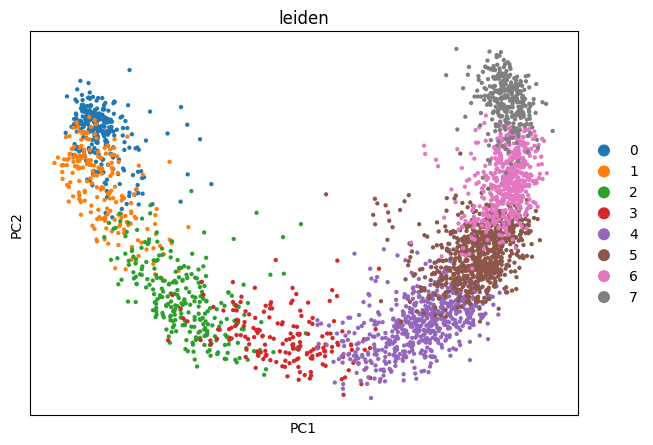

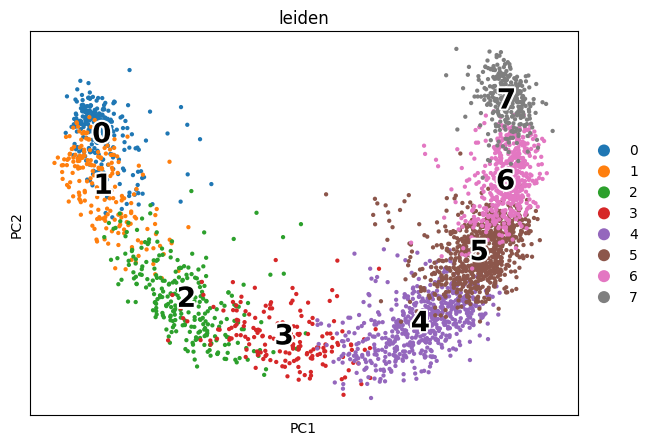

In [14]:
clusters = np.load('PAGA_DG.npy')
adata0.obs['leiden'] = clusters
adata0.obs['leiden'] = adata.obs['leiden']
adata0.obsm['X_pca'][:,0] = -adata0.obsm['X_pca'][:,0]

sc.pl.scatter(adata0, basis = 'pca', color='leiden', save = 'DG_clusters_PAGA.png')

ax = sc.pl.scatter(adata0, basis = 'pca', color='leiden', show=False)

cluster_centers = {}
for cluster in adata0.obs['leiden'].cat.categories:
    # 筛选属于当前聚类的所有细胞
    mask = adata0.obs['leiden'] == cluster
    # 提取这些细胞的UMAP坐标 (假设坐标存储在 'X_umap' 中)
    umap_coords = adata0.obsm['X_pca'][:,:2][mask]
    # 计算中心点（使用均值）
    center = np.mean(umap_coords, axis=0)
    cluster_centers[cluster] = center

import matplotlib.patheffects as PathEffects
# --------------- 添加聚类名称标签 ---------------
for cluster, (x, y) in cluster_centers.items():
    txt = ax.text(
        x, y, str(cluster),        # 坐标和文本
        fontsize=20,               # 字体大小
        weight='bold',             # 加粗
        ha='center', va='center',  # 水平/垂直居中
        color='black',             # 字体颜色
        bbox=dict(                 # 文本框样式
            facecolor = 'none',     # 背景色
            alpha=0.8,             # 透明度
            edgecolor='none',      # 边框颜色
            boxstyle='round'       # 圆角边框
        )
    )
# 关键步骤：添加白色描边，防止文字看不清
    txt.set_path_effects([
        PathEffects.withStroke(linewidth=3, foreground='white')
        ])
plt.savefig('DG_clusters_PAGA_labeled.png', dpi=300, bbox_inches='tight')
plt.show()
adata0.obsm['X_pca'][:,0] = -adata0.obsm['X_pca'][:,0]

In [15]:
cluster_color = adata0.uns['leiden_colors']

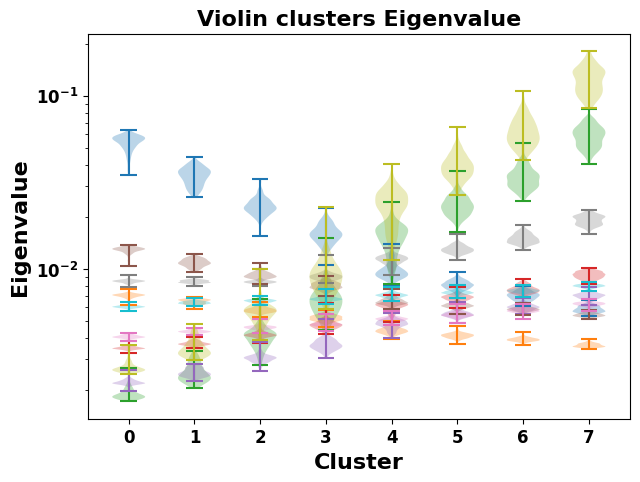

In [16]:
##不同颜色表示不同维度特征值
# categories = list(set(clusters[np.argsort(color_label)]))
# categories.sort(key = list(clusters[np.argsort(color_label)]).index)
categories = ['0','1','2','3','4','5','6','7']
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(7, 5))
#plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
for j in range(L):
    plt.violinplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
# 设置x轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories,fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')

plt.yscale('log')
# 添加标题和标签
plt.title('Violin clusters Eigenvalue',fontsize=16,weight='bold')
plt.xlabel('Cluster',fontsize=16,weight='bold')
plt.ylabel('Eigenvalue',fontsize=16,weight='bold')
plt.savefig(result_path+'violin')

plt.show()

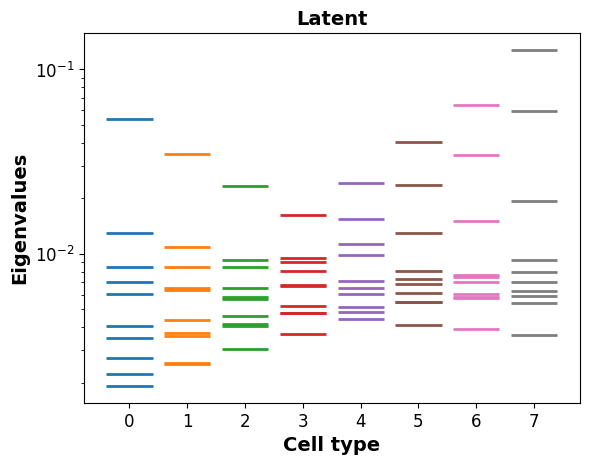

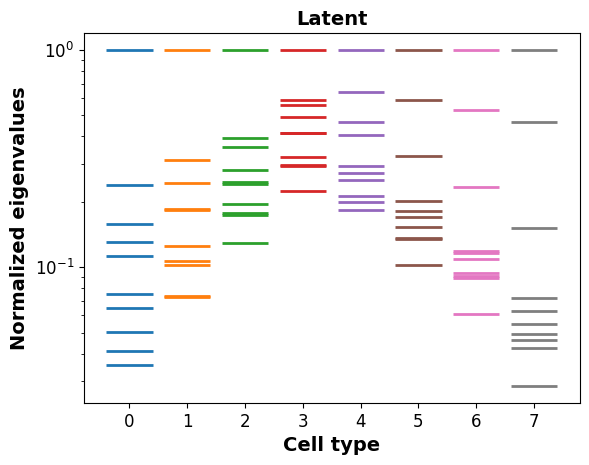

In [17]:
##cluster 均值

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories,fontsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=0)

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Latent', fontsize=14, fontweight='bold')
plt.savefig(result_path+'eigen_cluster.png')


plt.show()

##cluster 均值按照第一特征值归一

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)


fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y/np.max(y), x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories,fontsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=0)

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalized eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Latent', fontsize=14, fontweight='bold')
plt.savefig(result_path+'eigen_cluster_ratio.png')


plt.show()

In [18]:
#------use a simple neural network to study dmu/dt and dsigma/dt
latent_z = np.hstack((mu_learned,sigma_learned))
pca_dim = adata.obsm['X_pca'].shape[1]

model = nn.Sequential(
    nn.Linear(pca_dim, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_in=torch.tensor(X_pca.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
#     if epoch% 10 == 9:
#         print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

pZ_pX = np.zeros([X.shape[0], L*2, X_pca.shape[1]])

# Compute the gradients
for i in range(X.shape[0]):
    x0=torch.tensor(X_pca[i,:],requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pX[i,j,:] = x0.grad.detach()
        
Fisher_pca = np.zeros((X.shape[0],pca_dim, pca_dim))
for i in range(X.shape[0]):
    Fisher_pca[i] = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]

In [19]:
Fisher_pca_diag = np.zeros_like(Fisher_pca)
for i in range(X.shape[0]):
    Fisher_pca_diag[i] = np.abs(np.diag(np.linalg.eigh(Fisher_pca[i])[0]))
    
Eigenvalue = np.zeros((X.shape[0],pca_dim))
for i in range(X.shape[0]):
    for j in range(pca_dim):
        Eigenvalue[i,j] = Fisher_pca_diag[i,j,j]
Eigenvalue = np.sort(Eigenvalue, axis=1)
Eigenvalue = Eigenvalue[:, ::-1]

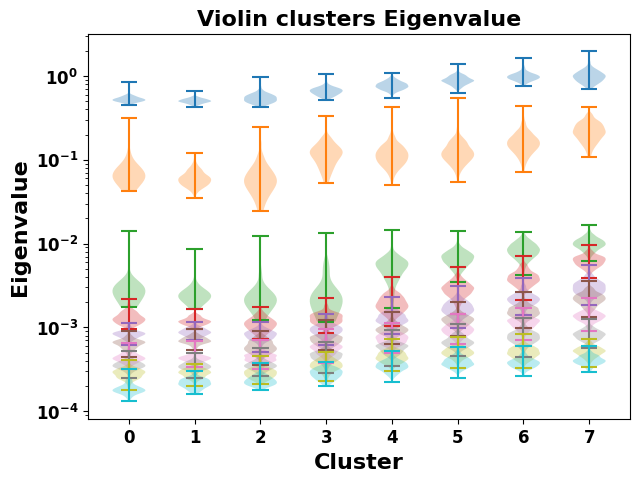

In [20]:
##不同颜色表示不同维度特征值
# categories = list(set(clusters[np.argsort(color_label)]))
# categories.sort(key = list(clusters[np.argsort(color_label)]).index)

categories
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(7, 5))
#plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
for j in range(L):
    plt.violinplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
# 设置x轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories,fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')

plt.yscale('log')
# 添加标题和标签
plt.title('Violin clusters Eigenvalue',fontsize=16,weight='bold')
plt.xlabel('Cluster',fontsize=16,weight='bold')
plt.ylabel('Eigenvalue',fontsize=16,weight='bold')
plt.savefig(result_path+'violin_pca')

plt.show()

## **Eigengene** ##

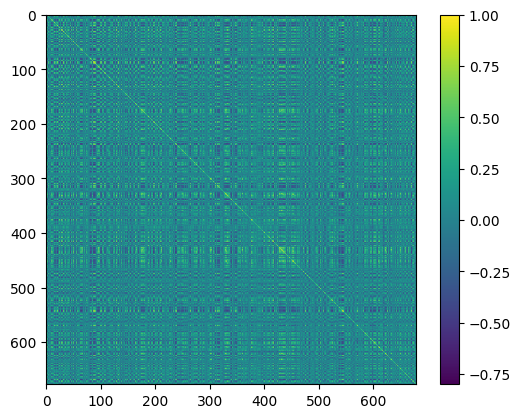

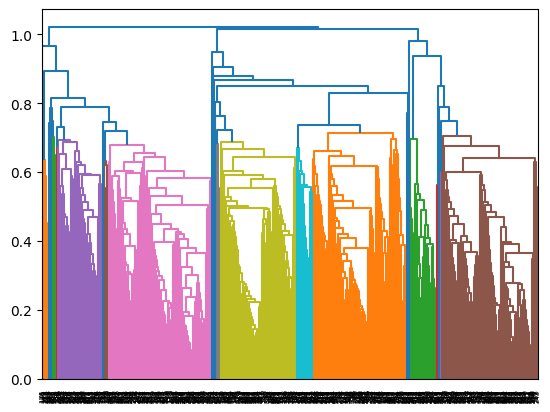

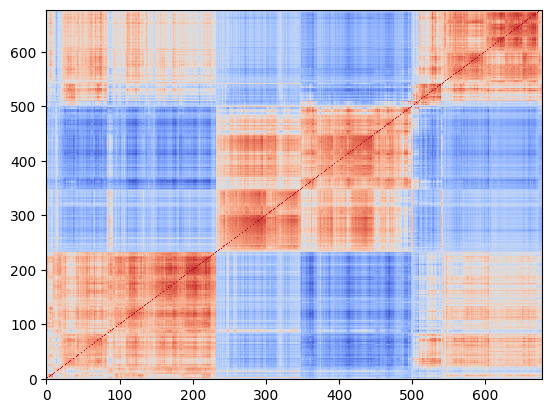

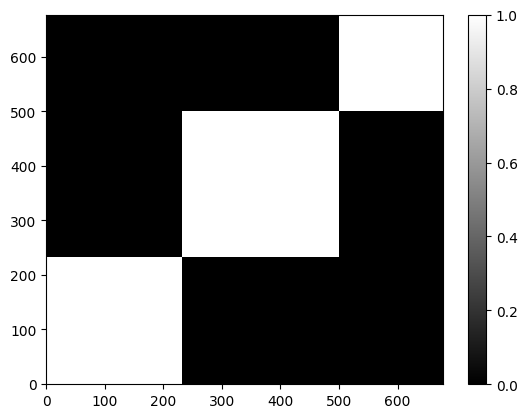

[0.45576048 0.08021189]
[0.42471874 0.13492687]
[0.4651478  0.11035526]
3
(3139, 20, 3)
tensor(0.3570, grad_fn=<MseLossBackward0>)


In [21]:
Xs = adata.layers['Ms']#adata.X.A#
Xu = adata.layers['Mu']
scaler = StandardScaler()#MinMaxScaler()#
X = scaler.fit_transform(Xs)

X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

X_corr_re=np.corrcoef(X_re, rowvar=False)
plt.show()
td = 0.99
T = fcluster(Z, t=td, criterion='distance')
# T=fcluster(Z, t=td, criterion='maxclust')
T_re = T[dg['leaves']]

plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
plt.show()

X_corr_label = np.zeros(X_corr_re.shape)
for i in range(X_corr_re.shape[0]):
    label_ind = np.where(T_re==T_re[i])[0]
    X_corr_label[i,label_ind] = 1

plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.gray, interpolation='nearest',origin='lower')
plt.colorbar()
plt.show()
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        pca=PCA(n_components=2).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_.T)
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w
eigen_X,eigen_X_w=eigen_gene(X_re,T_re)
eigen_dim=len(np.unique(T_re))
print(eigen_dim)
n_eigen = 1
cell_eigen_X = eigen_X[0,:,:n_eigen]
for i in range(eigen_dim-1):
    cell_eigen_X = np.hstack((cell_eigen_X,eigen_X[i+1,:,:n_eigen]))

from torch.optim import SGD
reset_seeds(0)

model = nn.Sequential(
    nn.Linear(cell_eigen_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.002, weight_decay=0.001)

x_in=torch.tensor(cell_eigen_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
    # print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Initialize a tensor to store the gradients
pZ_pEg = np.zeros([cell_eigen_X.shape[0], L*2, cell_eigen_X.shape[1]])

# Compute the gradients
for i in range(cell_eigen_X.shape[0]):
    x0=torch.tensor(cell_eigen_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pEg[i,j,:] = x0.grad.detach()
print(pZ_pEg.shape)
print(loss_fn(model(x_in),x_out))

Fisher_eigen = np.zeros((X.shape[0],eigen_dim*n_eigen,eigen_dim*n_eigen))
for i in range(X.shape[0]):
    Fisher_eigen[i] = pZ_pEg[i].T @ Fisher_g[i] @ pZ_pEg[i]

In [22]:
Fisher_eigen_diag = np.zeros_like(Fisher_eigen)
for i in range(X.shape[0]):
    Fisher_eigen_diag[i] = np.abs(np.diag(np.linalg.eigh(Fisher_eigen[i])[0]))
    
Eigenvalue = np.zeros((X.shape[0],eigen_dim))
for i in range(X.shape[0]):
    for j in range(eigen_dim):
        Eigenvalue[i,j] = Fisher_eigen_diag[i,j,j]
Eigenvalue = np.sort(Eigenvalue, axis=1)
Eigenvalue = Eigenvalue[:, ::-1]

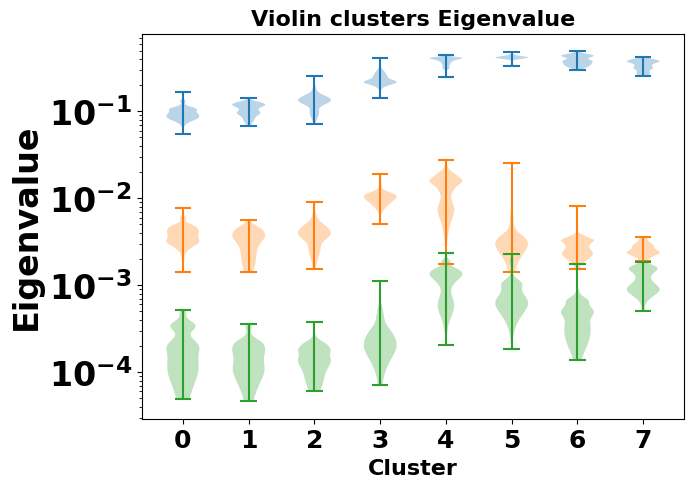

In [23]:
##不同颜色表示不同维度特征值
# categories = list(set(clusters[np.argsort(color_label)]))
# categories.sort(key = list(clusters[np.argsort(color_label)]).index)

categories
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(7, 5))
#plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
for j in range(3):
    plt.violinplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
# 设置x轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories,fontsize=18,fontweight='bold')
plt.yticks(fontsize=24,fontweight='bold')


plt.yscale('log')
# 添加标题和标签
plt.title('Violin clusters Eigenvalue',fontsize=16,weight='bold')
plt.xlabel('Cluster',fontsize=16,weight='bold')
plt.ylabel('Eigenvalue',fontsize=24,weight='bold')
plt.savefig(result_path+'violin_eigen')

plt.show()

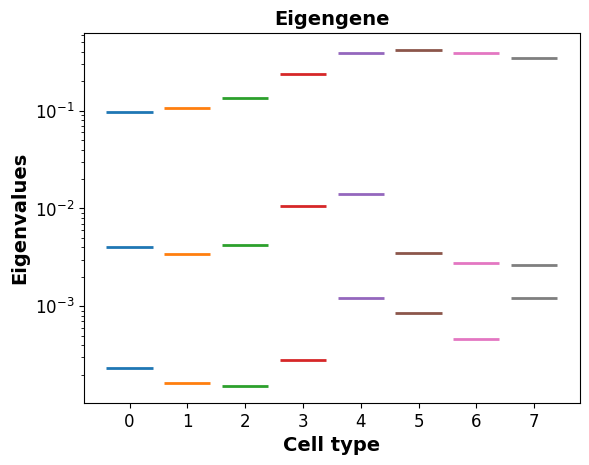

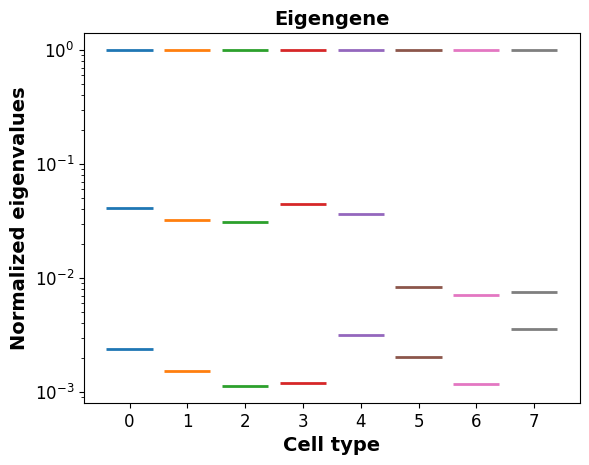

In [24]:
##cluster 均值

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category][0:L]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories,fontsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=0)

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Eigengene', fontsize=14, fontweight='bold')
plt.savefig(result_path+'eigen_cluster_eigengene.png')


plt.show()

##cluster 均值按照第一特征值归一

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)


fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category][0:L]
    x = np.full_like(y, i)
    ax.hlines(y[0:L]/np.max(y), x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories,fontsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=0)

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalized eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Eigengene', fontsize=14, fontweight='bold')
plt.savefig(result_path+'eigen_cluster_ratio_eigengene.png')


plt.show()

## **Hotspot** ##

In [25]:
import hotspot
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
hs = hotspot.Hotspot(
    adata, 
    model='danb',
    distances_obsp_key = 'distances'
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=k_nei,
)

hs_results = hs.compute_autocorrelations(jobs=1)

# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.1].sort_values('Z', ascending=False).head(800).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=1)

modules = hs.create_modules(
    min_gene_threshold=100, core_only=True, fdr_threshold=0.1
)

modules.value_counts()
# np.save(result_path+'modules', modules.values)
# np.save(result_path+'hs_genes', hs_genes)


# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        if i < 0:
            continue
        pca=PCA(n_components=2).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_[0,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w

adata_hs = adata[:,hs_genes] # 只用hotspot有效的gene
T_hs = np.array(hs.modules.tolist()) # 记录所有hs gene的module

scaler = StandardScaler()
X_hs = scaler.fit_transform(adata_hs.layers['Ms'])
hs_X, hs_X_w = eigen_gene(X_hs,T_hs)
hs_dim=len(hs_X_w)
print(hs_dim)

cell_hs_X=np.zeros((X_hs.shape[0],hs_dim))
for j in range(X_hs.shape[0]):
    for k in range(len(hs_X_w)):
        cell_hs_X[j,k]=np.dot(hs_X_w[k],X_hs[j,T_hs==k+1])

reset_seeds(0)

model = nn.Sequential(
    nn.Linear(cell_hs_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_in=torch.tensor(cell_hs_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
#         print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Initialize a tensor to store the gradients
pZ_phs = np.zeros([cell_hs_X.shape[0], L*2, cell_hs_X.shape[1]])

# Compute the gradients
for i in range(cell_hs_X.shape[0]):
    x0=torch.tensor(cell_hs_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_phs[i,j,:] = x0.grad.detach()
print(pZ_phs.shape)

Fisher_hs = np.zeros((X.shape[0],hs_dim, hs_dim))
for i in range(X.shape[0]):
    Fisher_hs[i] = pZ_phs[i].T@Fisher_g[i]@pZ_phs[i]

100%|██████████| 678/678 [00:00<00:00, 723.86it/s]


Computing pair-wise local correlation on 670 features...


100%|██████████| 224115/224115 [00:13<00:00, 16087.81it/s]


[0.4927525  0.05807352]
[0.46228793 0.11247507]
[0.42976987 0.13717869]
3
(3139, 20, 3)


In [26]:
Fisher_hs_diag = np.zeros_like(Fisher_hs)
for i in range(X.shape[0]):
    Fisher_hs_diag[i] = np.abs(np.diag(np.linalg.eigh(Fisher_hs[i])[0]))
    
Eigenvalue = np.zeros((X.shape[0],hs_dim))
for i in range(X.shape[0]):
    for j in range(hs_dim):
        Eigenvalue[i,j] = Fisher_hs_diag[i,j,j]
Eigenvalue = np.sort(Eigenvalue, axis=1)
Eigenvalue = Eigenvalue[:, ::-1]

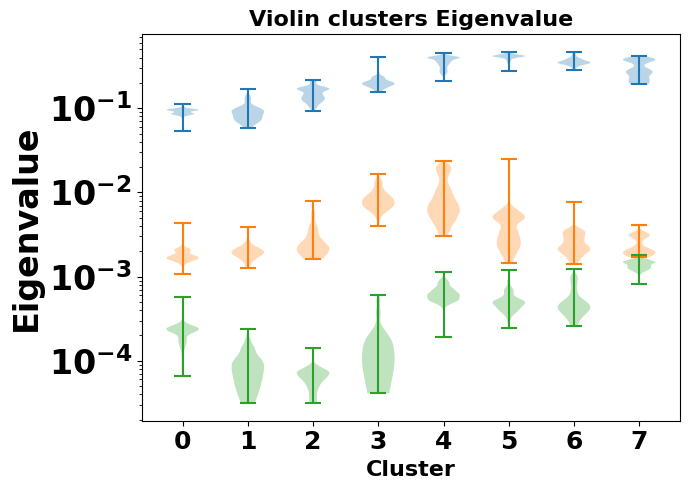

In [27]:
##不同颜色表示不同维度特征值
# categories = list(set(clusters[np.argsort(color_label)]))
# categories.sort(key = list(clusters[np.argsort(color_label)]).index)

categories
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(7, 5))
#plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
for j in range(3):
    plt.violinplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
# 设置x轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories,fontsize=18,fontweight='bold')
plt.yticks(fontsize=24,fontweight='bold')


plt.yscale('log')
# 添加标题和标签
plt.title('Violin clusters Eigenvalue',fontsize=16,weight='bold')
plt.xlabel('Cluster',fontsize=16,weight='bold')
plt.ylabel('Eigenvalue',fontsize=24,weight='bold')
plt.tight_layout()
plt.savefig(result_path+'violin_hotspot')


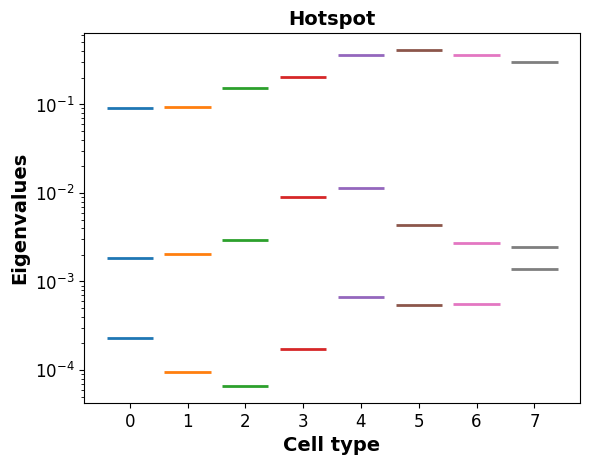

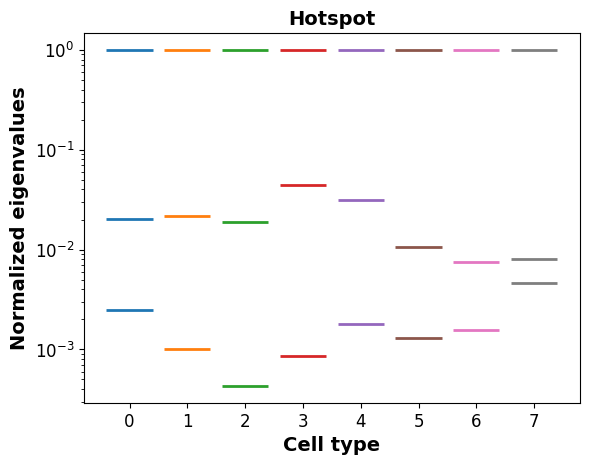

In [28]:
##cluster 均值

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category][0:L]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories,fontsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=0)

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Hotspot', fontsize=14, fontweight='bold')
plt.savefig(result_path+'eigen_cluster_hotspot.png')


plt.show()

##cluster 均值按照第一特征值归一

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)


fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category][0:L]
    x = np.full_like(y, i)
    ax.hlines(y/np.max(y), x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories,fontsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=0)

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalized eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Hotspot', fontsize=14, fontweight='bold')
plt.savefig(result_path+'eigen_cluster_ratio_hotspot.png')


plt.show()

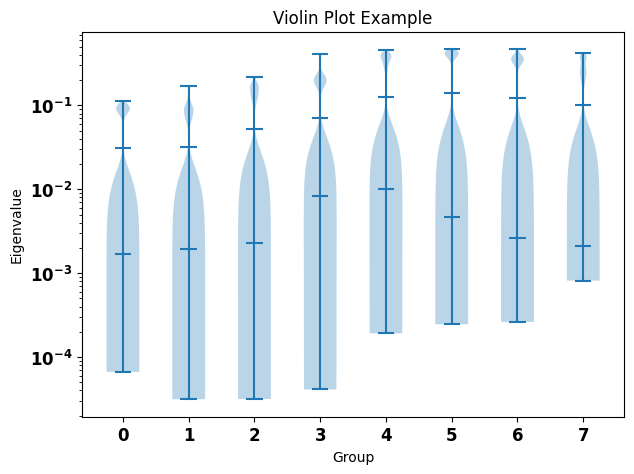

In [29]:
# 合并6个维度violinplot
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(7, 5))
plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
 
# 设置轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories,fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')

plt.yscale('log')

# 添加标题和标签
plt.title('Violin Plot Example')
plt.xlabel('Group')
plt.ylabel('Eigenvalue')
 
plt.show()